# AML Challenge

## Setup

In [1]:
# Loading libraries
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

In [4]:
# Loading data
account = pd.read_csv('Data/account.csv', sep = ';')
card = pd.read_csv('Data/card.csv', sep = ';')
client = pd.read_csv('Data/client.csv', sep = ';')
disp = pd.read_csv('Data/disp.csv', sep = ';')
district = pd.read_csv('Data/district.csv', sep = ';')
loan = pd.read_csv('Data/loan.csv', sep = ';')
order = pd.read_csv('Data/order.csv', sep = ';')
trans = pd.read_csv('Data/trans.csv', sep = ';')

C:\Users\chant\AppData\Local\Temp/ipykernel_10736/1677394057.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  trans = pd.read_csv('Data/trans.csv', sep = ';')


## Explorative Data Analysis

### Account
Data wrangling with the csv account. Here's a brief description from the website: 

In [6]:
print(account.head())

   account_id  district_id         frequency    date
0         576           55  POPLATEK MESICNE  930101
1        3818           74  POPLATEK MESICNE  930101
2         704           55  POPLATEK MESICNE  930101
3        2378           16  POPLATEK MESICNE  930101
4        2632           24  POPLATEK MESICNE  930102


It seems that the date column is wrong, let's fix that. 

In [7]:
# Fixing the date column
account['date'] = pd.to_datetime(account['date'], format='%y%m%d')
print(account.head())

   account_id  district_id         frequency       date
0         576           55  POPLATEK MESICNE 1993-01-01
1        3818           74  POPLATEK MESICNE 1993-01-01
2         704           55  POPLATEK MESICNE 1993-01-01
3        2378           16  POPLATEK MESICNE 1993-01-01
4        2632           24  POPLATEK MESICNE 1993-01-02


# Hier weiter

In [ ]:
# Translating the frequency into English


In [11]:
print(account.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   account_id   4500 non-null   int64         
 1   district_id  4500 non-null   int64         
 2   frequency    4500 non-null   object        
 3   date         4500 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 140.8+ KB
None


In [13]:
# Checking if there are any data missing
print(account.isnull().sum())

account_id     0
district_id    0
frequency      0
date           0
dtype: int64


In [15]:
print(account['account_id'].nunique())
print(account['district_id'].nunique())

4500
77


#### Summary EDA Account

There are 4500 unique clients in 77 districs. 

### Client

In [18]:
print(client.head)

<bound method NDFrame.head of       client_id  birth_number  district_id
0             1        706213           18
1             2        450204            1
2             3        406009            1
3             4        561201            5
4             5        605703            5
...         ...           ...          ...
5364      13955        456030            1
5365      13956        430406            1
5366      13968        680413           61
5367      13971        626019           67
5368      13998        535812           74

[5369 rows x 3 columns]>


In [22]:
# Changing the birth number into date of birth and gender. Code with ChatGPT: https://chatgpt.com/share/66f07472-2dbc-8002-9151-914f5c3aa6d6

# Funktion zur Umwandlung der Geburtsnummer in Geburtsdatum und Geschlecht
def extract_birthdate_and_gender(number):
    # Konvertiere die Zahl in einen String mit führenden Nullen
    number_str = str(number).zfill(6)
    
    # Extrahiere die Teile des Datums
    year = int(number_str[:2])  # Die ersten zwei Ziffern sind das Jahr
    month = int(number_str[2:4])  # Die nächsten zwei Ziffern sind der Monat
    day = int(number_str[4:6])  # Die letzten zwei Ziffern sind der Tag

    # Bestimme das Geschlecht und passe den Monat für Frauen an
    if month > 50:
        gender = 'female'
        month -= 50  # Subtrahiere 50 vom Monat für Frauen
    else:
        gender = 'male'

    # Bestimme das Jahr. Falls YY > 20, ordnen wir es dem 20. Jahrhundert zu, sonst dem 21.
    if year >= 50:  # Jahr größer gleich 50 -> 1900er (50-99)
        year += 1900
    else:  # Jahr kleiner 50 -> 2000er (00-49)
        year += 2000

    # Erstelle das Datum
    date_of_birth = pd.Timestamp(year=year, month=month, day=day)

    return date_of_birth, gender

# Wende die Funktion auf die Spalte 'birthnumber' an
client['date_of_birth'], client['gender'] = zip(*client['birth_number'].apply(extract_birthdate_and_gender))

# Zeige das Ergebnis an
print(client.head())

   client_id  birth_number  district_id date_of_birth  gender
0          1        706213           18    1970-12-13  female
1          2        450204            1    2045-02-04    male
2          3        406009            1    2040-10-09  female
3          4        561201            5    1956-12-01    male
4          5        605703            5    1960-07-03  female


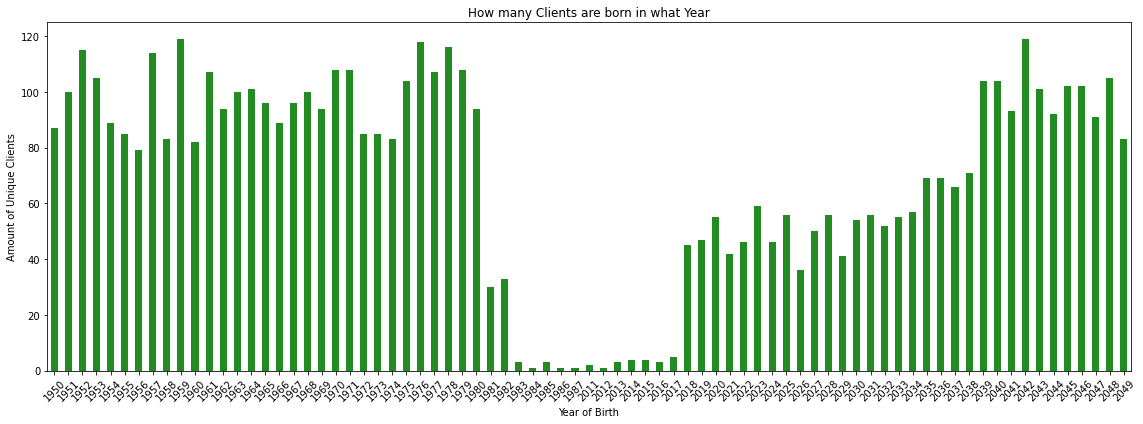

In [25]:
client['birth_year'] = pd.to_datetime(client['date_of_birth']).dt.year
client_count_per_year = client.groupby('birth_year')['client_id'].nunique()

# Plot
plt.figure(figsize=(16, 6))
client_count_per_year.plot(kind='bar', color='forestgreen')
plt.title('How many Clients are born in what Year')
plt.xlabel('Year of Birth')
plt.ylabel('Amount of Unique Clients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Explanation of the plot: There seems to be an error in the code or in the data as some clients are not even born yet but they still have an account. 

# Error